# A simple notebook to compute some statistics about theses in DiVA examined by Gerald Q. Maguire Jr.

The program fetches data from DiVA as a feed, using the URL shown as 'url' below. Unlike the previous program, this program fetches the data as a MODS feed.


DiVA (https://www.diva-portal.org) is a digital repository used by ~50 institutions (mainly in the Nordics). SInce ~2010, the theses from all first and second-cycle degree projects should have their metadata in DiVA. In many cases, the full text of the thesis is also available.


## Get some data and start processing it

In [1]:
# compute statistics over thesis data from DiVA

# libraries
import json
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from io import StringIO
import os
import time

import pymods
from pprint import pprint
#
#from eulxml import xmlmap
#from eulxml.xmlmap import load_xmlobject_from_file, mods
#import lxml.etree as etree

#from collections import defaultdict

#from bs4 import BeautifulSoup


def is_file_older_than_x_days(file, days=1): 
    file_time = os.path.getmtime(file) 
    # Check against 24 hours 
    return ((time.time() - file_time) / 3600 > 24*days)

# define a function to compute lower case Roman numeras from an integer
def int_to_roman(num):
    res = ""
    table = [
        (1000, "m"),
        (900, "cm"),
        (500, "d"),
        (400, "cd"),
        (100, "c"),
        (90, "xc"),
        (50, "l"),
        (40, "xl"),
        (10, "x"),
        (9, "ix"),
        (5, "v"),
        (4, "iv"),
        (1, "i"),
    ]
    for cap, roman in table:
        d, m = divmod(num, cap)
        res += roman * d
        num = m
    return res

# Using the above function fill a dict with the lower case Roman numerals from 0 to 499
# These are precomputed, so later we can simply do a lookup of the string and et the integer.
roman_table=dict()
for i in range(0,500):
    roman_table[int_to_roman(i)]=i

def collect_originInfo(mod_elem):
    originInfo=dict()
    for elem in mod_elem:
        if elem.tag.count("}languageTerm") == 1:
            if elem.text is not None:
                originInfo["LanguageTerm"]=elem.text
        elif elem.tag.count("}dateIssued") == 1:
            if elem.text is not None:
                originInfo["dateIssued"]=elem.text
        elif elem.tag.count("}dateOther") == 1:
            if elem.text is not None:
                originInfo["dateOther"]=elem.text
        elif elem.tag.count("}place") == 1:
            if elem.text is not None:
                originInfo["place"]=elem.text
        elif elem.tag.count("}publisher") == 1:
            if elem.text is not None:
                originInfo["publisher"]=elem.text
        else:
            print("Unhandled case in collect_originInfo: {}".format(elem))
    return originInfo

# The starting year is arbitrarly fixed to 1990 - as I had no degree projects a KTH prior to this (since it is well before I came to KTH).
starting_year='1990'
current_year = date.today().year
examiner='maguire'
filename=f'./examiner-{examiner}-{current_year}.mods'
Verbose_Flag=True

if os.path.exists(filename) and not is_file_older_than_x_days(filename,1):
    mods_records = pymods.MODSReader(filename)
else:
    # URL of the DiVA feed
    # the maximum number of theses was arbitrarily set to 5000
    url='https://kth.diva-portal.org/smash/export.jsf?format=mods&addFilename=true&aq=[[{"examiner":["'+f'{examiner}'+'"]}]]&aqe=[]&aq2=[[{"dateIssued":{"from":"'+f'{starting_year}'+'","to":"'+f'{current_year}'+'"}},{"organisationId":"879223","organisationId-Xtra":true},{"publicationTypeCode":["studentThesis"]}]]&onlyFullText=false&noOfRows=5000&sortOrder=title_sort_asc&sortOrder2=title_sort_asc'
    print("url={}".format(url))
    req = urllib.request.Request(url)
    try:
        with urllib.request.urlopen(req) as response:
            data_str=response.read()
    except urllib.error.HTTPError as e:
        print(e.code)
        print(e.read())

    with open(filename, "wb") as mods_data_file:
        mods_data_file.write(data_str)
    mods_records = pymods.MODSReader(filename)



In [2]:
df=pd.DataFrame()
index=0
for record in mods_records:
    index=index+1
    diva_entry=dict()
    diva_entry['node']=index
    #if index > 10:
    #    break
    print(record.tag)
    if record.tag.count("}mods") == 1:
        #print("Attribute: {}".format(record.attrib))
        for mod_element in record:
            print(mod_element)
            if mod_element.tag.count("}genre") == 1:
                #print("attribute ={}".format(mod_element.attrib))
                #print("text ={}".format(mod_element.text))
                if mod_element.attrib.get('type') == "publicationTypeCode":
                    diva_entry['publicationTypeCode']=mod_element.text
                elif mod_element.attrib.get('type') == "publicationType":
                    current_pubtype=diva_entry.get('publicationType', dict())
                    current_pubtype.update({mod_element.attrib.get('lang'): mod_element.text})
                    diva_entry['publicationType']=current_pubtype
                else:
                    print("Unhandled case in publicationType")
            elif mod_element.tag.count("}name") == 1:
                # <name type="personal" authority="kth" xlink:href="u19gy7zg">
                if mod_element.attrib.get('type') == "personal":
                    name_type='personal'
                elif mod_element.attrib.get('type') == "corporate":
                    name_type='corporate'
                else:
                    name_type='unknown'
            elif mod_element.tag.count("}titleInfo") == 1:
                #current_titleInfo=diva_entry.get('titleInfo', dict())
                #diva_entry['titleInfo']=current_titleInfo
                lang=mod_element.attrib.get('lang')
                for elem in mod_element:
                    if elem.tag.count("}title") == 1:
                        #current_title=current_titleInfo.get('title', dict())
                        current_title=diva_entry.get('title', dict())
                        current_title.update({lang: elem.text})
                        diva_entry['title']=current_title
                    elif elem.tag.count("}subTitle") == 1:
                        #current_subtitle=current_titleInfo.get('subtitle', dict())
                        current_subtitle=diva_entry.get('subtitle', dict())
                        current_subtitle.update({lang: elem.text})
                        diva_entry['subtitle']=current_subtitle
                    else:
                        print("Unhandled case in titleInfo")
            elif mod_element.tag.count("}language") == 1:
                i=0
                temp_dict=dict()
                for elem in mod_element:
                    i=i+1
                    if elem.tag.count("}languageTerm") == 1:
                        if elem.text is not None:
                            name='languageTerm_{0}'.format(i)
                            temp_dict[name]=[elem.text]
                    elif elem.tag.count("}dateIssued") == 1:
                        if elem.text is not None:
                            if Verbose_Flag:
                                print("dateIssued: ".format(elem.text))
                            name='dateIssued_{0}'.format(i)
                            temp_dict[name]=[elem.text]
                    elif elem.tag.count("}dateOther") == 1:
                        if elem.text is not None:
                            if Verbose_Flag:
                                print("dateOther: {0}{1}".format(elem.attrib, elem.text))
                            name='dateOther_{0}'.format(i)
                            temp_dict[name]=[elem.text]
                    else:
                        if Verbose_Flag:
                            print("mod_emem[" + str(i) +"]".format(elem))
                        name='language_{0}'.format(i)
                        temp_dict[name]=[elem.text]
                print("temp_dict={}".format(temp_dict))
            elif mod_element.tag.count("}originInfo") == 1:
                diva_entry['originInfo']=collect_originInfo(mod_element)
                diva_entry['Year']=diva_entry['originInfo'].get("dateIssued", 'Unknown year')
            elif mod_element.tag.count("}identifier") == 1:
                if mod_element.text is not None and mod_element.attrib.get('type') == "url":
                    diva_entry['url']=mod_element.text
            elif mod_element.tag.count("}abstract") == 1:
                current_abstracts=diva_entry.get('abstract', dict())
                lang=mod_element.attrib.get('lang')
                current_abstracts.update({lang: mod_element.text})
                diva_entry['abstract']=current_abstracts
            elif mod_element.tag.count("}subject") == 1:
                #<subject lang="eng" xlink:href="9895"><topic>Master of Science - Computer Science</topic><genre>Educational program</genre></subject>
                #<subject lang="swe" xlink:href="9895"><topic>Teknologie masterexamen - Datalogi</topic><genre>Educational program</genre></subject>
                #<subject lang="eng" xlink:href="10280"><topic>Computer Science</topic><genre>Subject/course</genre></subject>
                #<subject lang="swe" xlink:href="10280"><topic>Datalogi</topic><genre>Subject/course</genre></subject>
                xlink=mod_element.attrib.get('{http://www.w3.org/1999/xlink}href', None)
                xlinks=mod_element.attrib.get('xlink', None)
                authority=mod_element.attrib.get('authority', None)
                if authority:
                    subject=f'{authority}'
                elif xlink:    
                    subject='xlink' 
                elif xlinks:    
                    subject='xlinks' 
                else:
                    subject='keywords'
                lang=mod_element.attrib.get('lang')
                current_subject=diva_entry.get(subject, dict())
                topics=current_subject.get(lang, list())
                for elem in mod_element:
                    if elem.tag.count("}topic") == 1:
                        topics.append(elem.text)
                current_subject.update({lang: topics})
                diva_entry[subject]=current_subject
            elif mod_element.tag.count("}recordInfo") == 1:
                #<recordInfo>
                #<recordOrigin>u1d13i2c</recordOrigin>
                #<recordContentSource>kth</recordContentSource>
                #<recordCreationDate>2019-06-26</recordCreationDate>
                #<recordChangeDate>2022-06-26</recordChangeDate>
                #<recordIdentifier>diva2:1330685</recordIdentifier>
                #</recordInfo>
                current_recordInfo=diva_entry.get('recordInfo', dict())
                for elem in mod_element:
                    if elem.tag.count("}recordOrigin") == 1:
                        current_recordInfo["recordOrigin"]=elem.text
                    elif elem.tag.count("}recordContentSource") == 1:
                        current_recordInfo["recordContentSource"]=elem.text
                    elif elem.tag.count("}recordCreationDate") == 1:
                        current_recordInfo["recordCreationDate"]=elem.text
                    elif elem.tag.count("}recordChangeDate") == 1:
                        current_recordInfo["recordChangeDate"]=elem.text
                    elif elem.tag.count("}recordIdentifier") == 1:
                        current_recordInfo["recordIdentifier"]=elem.text
                    else:
                        print("unhandled case in recordInfo")
                diva_entry['recordInfo']=current_recordInfo
            elif mod_element.tag.count("}location") == 1:
                # <location><url displayLabel="fulltext" note="free" access="raw object">http://kth.diva-portal.org/smash/get/diva2:821850/FULLTEXT01.pdf</url></location>
                current_location=diva_entry.get('location', dict())
                for elem in mod_element:
                    if elem.tag.count("}url") == 1:
                        label=elem.attrib.get('displayLabel', None)
                        if label:
                            current_location[label]=elem.text
                        else:
                            current_location["url"]=elem.text
                    else:
                        print("Unhandled case in }location")
                diva_entry['location']=current_location
            elif mod_element.tag.count("}typeOfResource") == 1:
                # <typeOfResource>text</typeOfResource>
                diva_entry['typeOfResource']=mod_element.text
            elif mod_element.tag.count("}relatedItem") == 1:            
                #<relatedItem type="series">
                #  <titleInfo><title>Trita-ICT-COS</title></titleInfo>
                #  <identifier type="issn">1653-6347</identifier>
                #  <identifier type="local">247</identifier>
                #  <identifier type="issue number">COS/CCS 2007-24</identifier>
                #</relatedItem>
                relatedItemType=mod_element.attrib.get('type', None)
                if not relatedItemType:
                    relatedItemType='relatedItem'
                titleInfo=dict()
                for elem in mod_element:
                    if elem.tag.count("}titleInfo") == 1:
                        for title in elem:
                            titleInfo["title"]=title.text
                    elif elem.tag.count("}identifier") == 1:
                        identifier_type=elem.attrib.get('type', None)
                        if identifier_type == "issue number":
                            identifier_type="issue_number"
                        titleInfo[f"{identifier_type}"]=elem.text
                diva_entry[relatedItemType]=titleInfo
            elif mod_element.tag.count("}physicalDescription") == 1:
                #<physicalDescription>
                #  <form authority="marcform">electronic</form>
                #  <extent>xii,74</extent></physicalDescription>
                 for elem in mod_element:
                    if elem.tag.count("}extent") == 1:
                        diva_entry['Pages']=elem.text
            elif mod_element.tag.count("}note") == 1:
                #<note type="level" lang="swe">Självständigt arbete på avancerad nivå (masterexamen)</note>
                #<note type="universityCredits" lang="swe">20 poäng / 30 hp</note>
                #<note type="cooperation">Saab AB</note>
                type=mod_element.attrib.get('type', None)
                if type=="level":
                    diva_entry["level"]=mod_element.text
                elif type=="universityCredits":
                    diva_entry["universityCredits"]=mod_element.text
                elif type=="cooperation":
                    diva_entry["cooperation"]=mod_element.text
                else:
                    print("unhandled case fo }note")
            else:
                print("Unhandled case in }mod")
        #pprint(diva_entry)
        df2 = pd.json_normalize(diva_entry)
    df=df.append(df2, ignore_index = True) 


<Element {http://www.loc.gov/mods/v3}genre at 0x7f947cd89ae0>
<Element {http://www.loc.gov/mods/v3}genre at 0x7f947cd893b0>
<Element {http://www.loc.gov/mods/v3}genre at 0x7f947cd90b80>
<Element {http://www.loc.gov/mods/v3}genre at 0x7f947cd89ae0>
<Element {http://www.loc.gov/mods/v3}genre at 0x7f947cd90a90>
<Element {http://www.loc.gov/mods/v3}name at 0x7f947cd90b80>
<Element {http://www.loc.gov/mods/v3}name at 0x7f947cd89ae0>
<Element {http://www.loc.gov/mods/v3}name at 0x7f947cd90a90>
<Element {http://www.loc.gov/mods/v3}name at 0x7f947cd90b80>
<Element {http://www.loc.gov/mods/v3}name at 0x7f947cd89ae0>
<Element {http://www.loc.gov/mods/v3}name at 0x7f947cd90a90>
<Element {http://www.loc.gov/mods/v3}name at 0x7f947cd90b80>
<Element {http://www.loc.gov/mods/v3}titleInfo at 0x7f947cd89ae0>
<Element {http://www.loc.gov/mods/v3}language at 0x7f947cd90a90>
temp_dict={'languageTerm_1': ['eng']}
<Element {http://www.loc.gov/mods/v3}titleInfo at 0x7f947cd904f0>
<Element {http://www.loc.gov

## Calculate the total number of pages in each thesis

The number of pages is either (1) an integer or (2) a combination of the numbe rof preface pages (as lower case Roman numerals) followed by a comma and an integer. Otherwise, we will treat the number of pages as being zero (0), i.e., unknown. Note that there is at least one case where the separator is a period and not a comma.

Add the calculated number of pages as a new column in the dataframe.

In [3]:

for idx, row in df.iterrows():
    pages=row['Pages']
    if isinstance(pages, str) and ',' in pages:
        preface, body = pages.split(',')
        df.loc[idx, 'total_pages']=roman_table[preface]+int(body)
    elif isinstance(pages, str) and '.' in pages:
        preface, body = pages.split('.')
        df.loc[idx, 'total_pages']=roman_table[preface]+int(body)
    elif isinstance(pages, str):
        df.loc[idx, 'total_pages']=int(pages)
    else:
        df.loc[idx, 'total_pages']=0


# show the total_pages values as a plot
bins=[]
for b in range(0, round(int(df['total_pages'].max()+50), -1), 10):
    bins.append(b)
print("total_pages mas={}".format(df['total_pages'].max()))
#df[['total_pages']] = df[['total_pages']].apply(pd.to_numeric)
#hist_tp=plt.hist(df['total_pages'], bins=bins)
freq_df=pd.DataFrame(df['total_pages'].value_counts(bins=bins))
freq_df=freq_df.reset_index()
freq_df.columns=['number of pages', 'count']
for idx, row in freq_df.iterrows():
 	freq_df.loc[idx, 'base']=row['number of pages'].left

freq_df.sort_values(by='base', ignore_index=True, ascending=True)
freq_df = freq_df.drop('number of pages', axis=1)


total_pages mas=455.0


In [4]:
df

node publicationTypeCode  Year    Pages typeOfResource  \
0       1       studentThesis  2004       46           text   
1       2       studentThesis  2015  xiii,40           text   
2       3       studentThesis  2001      183           text   
3       4       studentThesis  2003       96           text   
4       5       studentThesis  2002      112           text   
..    ...                 ...   ...      ...            ...   
433   434       studentThesis  2018   xii,74           text   
434   435       studentThesis  2005       49           text   
435   436       studentThesis  2014   xiv,56           text   
436   437       studentThesis  1998       68           text   
437   438       studentThesis  2021       73           text   

                                                 level universityCredits  \
0    Självständigt arbete på avancerad nivå (master...  20 poäng / 30 hp   
1    Självständigt arbete på avancerad nivå (master...  20 poäng / 30 hp   
2    Självständigt arbete på avancerad nivå (master...  20 poäng / 30 hp   
3    Självständigt arbete på avancerad nivå (master...  20 poäng / 30 hp   
4    Självständigt arbete på avancerad nivå (master...  20 poäng / 30 hp   
..                                                 ...               ...   
433  Självständigt arbete på avancerad nivå (master...  20 poäng / 30 hp   
434  Självständigt arbete på avancerad nivå (master...  20 poäng / 30 hp   
435  Självständigt arbete på avancerad nivå (master...  20 poäng / 30 hp   
436  Självständigt arbete på avancerad nivå (master...  20 poäng / 30 hp   
437  Självständigt arbete på avancerad nivå (master...  20 poäng / 30 hp   

    publicationType.eng             publicationType.swe publicationType.nor  \
0                  book  Studentuppsats (Examensarbete)             Oppgave   
1                  book  Studentuppsats (Examensarbete)             Oppgave   
2                  book  Studentuppsats (Examensarbete)             Oppgave   
3                  book  Studentuppsats (Examensarbete)             Oppgave   
4                  book  Studentuppsats (Examensarbete)             Oppgave   
..                  ...                             ...                 ...   
433                book  Studentuppsats (Examensarbete)             Oppgave   
434                book  Studentuppsats (Examensarbete)             Oppgave   
435                book  Studentuppsats (Examensarbete)             Oppgave   
436                book  Studentuppsats (Examensarbete)             Oppgave   
437                book  Studentuppsats (Examensarbete)             Oppgave   

     ... abstract.fre location.software location.errata keywords.fre kth.eng  \
0    ...          NaN               NaN             NaN          NaN     NaN   
1    ...          NaN               NaN             NaN          NaN     NaN   
2    ...          NaN               NaN             NaN          NaN     NaN   
3    ...          NaN               NaN             NaN          NaN     NaN   
4    ...          NaN               NaN             NaN          NaN     NaN   
..   ...          ...               ...             ...          ...     ...   
433  ...          NaN               NaN             NaN          NaN     NaN   
434  ...          NaN               NaN             NaN          NaN     NaN   
435  ...          NaN               NaN             NaN          NaN     NaN   
436  ...          NaN               NaN             NaN          NaN     NaN   
437  ...          NaN               NaN             NaN          NaN     NaN   

    kth.swe keywords.spa                 keywords.chi  \
0       NaN          NaN                          NaN   
1       NaN          NaN                          NaN   
2       NaN          NaN                          NaN   
3       NaN          NaN                          NaN   
4       NaN          NaN                          NaN   
..      ...          ...                          ...   
433     NaN          NaN  

From the histogram below, we can see that there are a number of theses that did not have a length in DiVA and these have been interpreted has having zero, i.e., 0, lenght. One can easily see that the distribut is pretty well 

In [5]:
_deepnote_run_altair(freq_df, """{"data":{"name":"placeholder"},"mark":{"type":"bar","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"bin":false,"sort":{"order":"ascending","encoding":"x"},"type":"quantitative","field":"base","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"count","scale":{"type":"linear","zero":true}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

Calculate and show some additional statistics such as PDF an CDF.

In [6]:
# Frequency
stats_df = df \
.groupby('total_pages') \
['total_pages'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'total_pages': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()
stats_df

total_pages  frequency       pdf       cdf
0            0.0          8  0.018265  0.018265
1           18.0          1  0.002283  0.020548
2           24.0          2  0.004566  0.025114
3           27.0          1  0.002283  0.027397
4           28.0          2  0.004566  0.031963
..           ...        ...       ...       ...
123        251.0          1  0.002283  0.990868
124        269.0          1  0.002283  0.993151
125        271.0          1  0.002283  0.995434
126        377.0          1  0.002283  0.997717
127        455.0          1  0.002283  1.000000

[128 rows x 4 columns]

In [7]:
_deepnote_run_altair(stats_df, """{"data":{"name":"placeholder"},"mark":{"type":"bar","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"total_pages","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"pdf","scale":{"type":"linear","zero":true}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [8]:
_deepnote_run_altair(stats_df, """{"data":{"name":"placeholder"},"mark":{"type":"line","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"total_pages","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"cdf","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [9]:
_deepnote_run_altair(df, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Year","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"total_pages","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [10]:
_deepnote_run_altair(df, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Year","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"total_pages","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

## Make a word cloud based on the English keywords

To make word clouds you need to install the wordcloud package into your compute (or the firstual computer). In the case of deepnote you can add to the requirements.tx file a list of version of the packages that you need, in this case a line saying:

wordcloud==1.8.2.2

Note that the keywords are  tagged with the language.

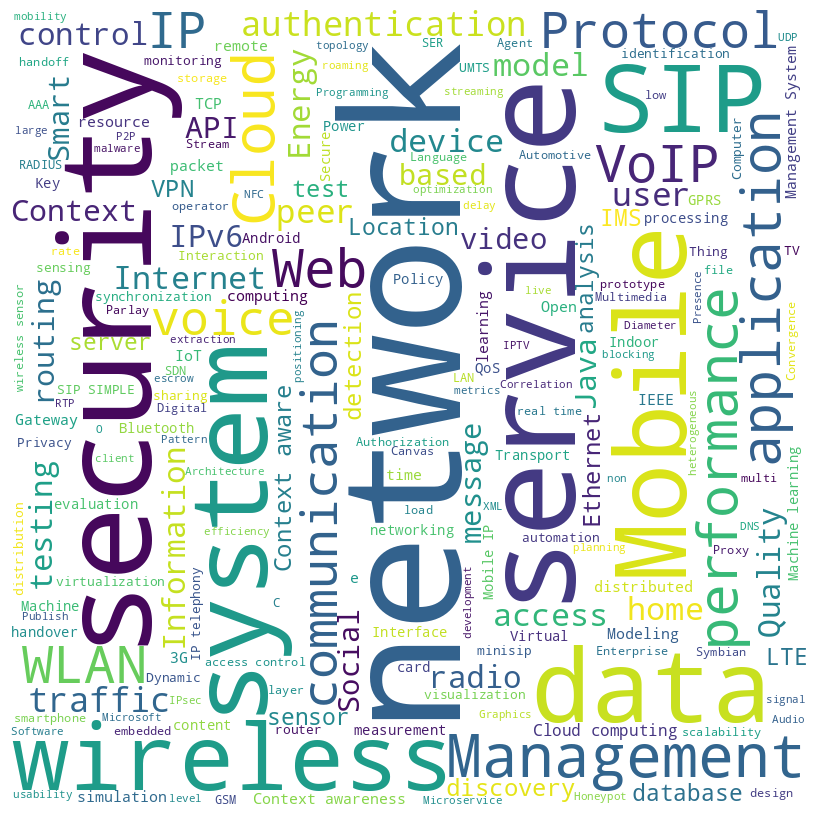

In [11]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
stopwords.add('nan')
stopwords.add('NA')

for idx, row in df.iterrows():
    tokens = row['keywords.eng']
    if isinstance(tokens, float):
        continue
    # Converts each token into lowercase
    for i in range(len(tokens)):
        if any(map(str.isupper, tokens[i])):
            tokens[i] = tokens[i]
        else:
            tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Make a word cloud based on the Swedish keywords

This list of Swedish stopwords was computed in an earlier project that I did looking at thesis abstracts. See the program check_abstracts.py in https://github.com/gqmaguirejr/DiVA-tools .

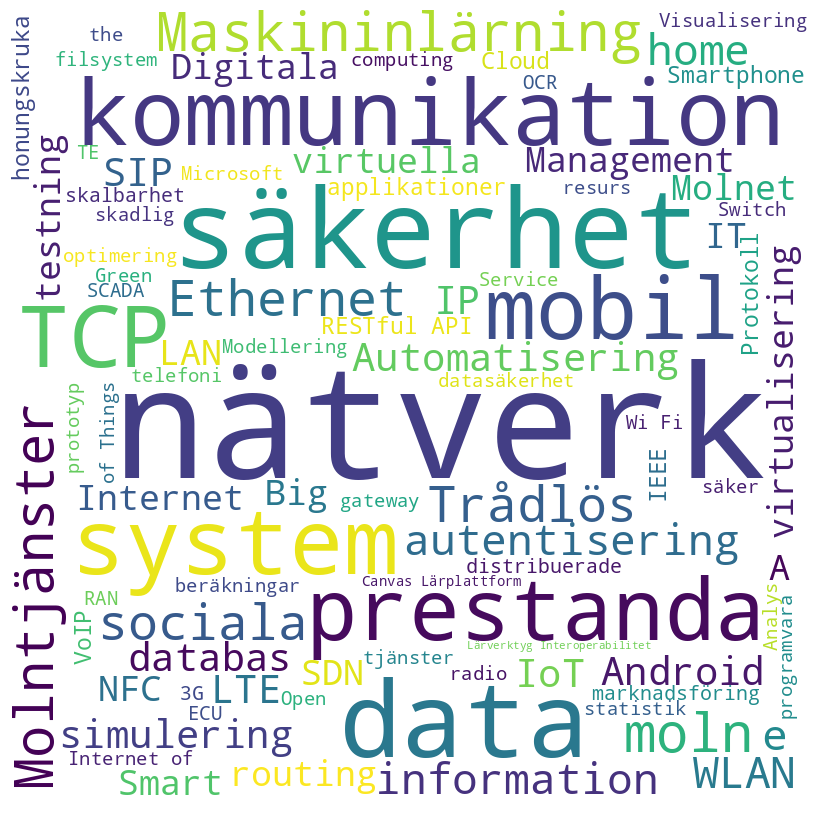

In [12]:
SwedishStopWords=[
    u'aderton',
    u'adertonde',
    u'adjö',
    u'aldrig',
    u'alla',
    u'allas',
    u'allt',
    u'alltid',
    u'alltså',
    u'än',
    u'andra',
    u'andras',
    u'annan',
    u'annat',
    u'ännu',
    u'artonde',
    u'artonn',
    u'åtminstone',
    u'att',
    u'åtta',
    u'åttio',
    u'åttionde',
    u'åttonde',
    u'av',
    u'även',
    u'båda',
    u'bådas',
    u'bakom',
    u'bara',
    u'bäst',
    u'bättre',
    u'behöva',
    u'behövas',
    u'behövde',
    u'behövt',
    u'beslut',
    u'beslutat',
    u'beslutit',
    u'bland',
    u'blev',
    u'bli',
    u'blir',
    u'blivit',
    u'bort',
    u'borta',
    u'bra',
    u'då',
    u'dag',
    u'dagar',
    u'dagarna',
    u'dagen',
    u'där',
    u'därför',
    u'de',
    u'del',
    u'delen',
    u'dem',
    u'den',
    u'deras',
    u'dess',
    u'det',
    u'detta',
    u'dig',
    u'din',
    u'dina',
    u'dit',
    u'ditt',
    u'dock',
    u'du',
    u'efter',
    u'eftersom',
    u'elfte',
    u'eller',
    u'elva',
    u'en',
    u'enkel',
    u'enkelt',
    u'enkla',
    u'enligt',
    u'er',
    u'era',
    u'ert',
    u'ett',
    u'ettusen',
    u'få ',
    u'fanns',
    u'får',
    u'fått ',
    u'fem',
    u'femte',
    u'femtio',
    u'femtionde',
    u'femton',
    u'femtonde',
    u'fick',
    u'fin',
    u'finnas',
    u'finns',
    u'fjärde',
    u'fjorton',
    u'fjortonde',
    u'fler',
    u'flera',
    u'flesta',
    u'följande',
    u'för',
    u'före',
    u'förlåt',
    u'förra',
    u'första',
    u'fram',
    u'framför',
    u'från',
    u'fyra',
    u'fyrtio',
    u'fyrtionde',
    u'gå',
    u'gälla',
    u'gäller',
    u'gällt',
    u'går',
    u'gärna',
    u'gått',
    u'genast',
    u'genom',
    u'gick',
    u'gjorde',
    u'gjort',
    u'god',
    u'goda',
    u'godare',
    u'godast',
    u'gör',
    u'göra',
    u'gott',
    u'ha',
    u'hade',
    u'haft',
    u'han',
    u'hans',
    u'har',
    u'här',
    u'heller',
    u'hellre',
    u'helst',
    u'helt',
    u'henne',
    u'hennes',
    u'hit',
    u'hög',
    u'höger',
    u'högre',
    u'högst',
    u'hon',
    u'honom',
    u'hundra',
    u'hundraen',
    u'hundraett',
    u'hur',
    u'i',
    u'ibland',
    u'idag',
    u'igår',
    u'igen',
    u'imorgon',
    u'in',
    u'inför',
    u'inga',
    u'ingen',
    u'ingenting',
    u'inget',
    u'innan',
    u'inne',
    u'inom',
    u'inte',
    u'inuti',
    u'ja',
    u'jag',
    u'jämfört',
    u'kan',
    u'kanske',
    u'knappast',
    u'kom',
    u'komma',
    u'kommer',
    u'kommit',
    u'kr',
    u'kunde',
    u'kunna',
    u'kunnat',
    u'kvar',
    u'länge',
    u'längre',
    u'långsam',
    u'långsammare',
    u'långsammast',
    u'långsamt',
    u'längst',
    u'långt',
    u'lätt',
    u'lättare',
    u'lättast',
    u'legat',
    u'ligga',
    u'ligger',
    u'lika',
    u'likställd',
    u'likställda',
    u'lilla',
    u'lite',
    u'liten',
    u'litet',
    u'man',
    u'många',
    u'måste',
    u'med',
    u'mellan',
    u'men',
    u'mer',
    u'mera',
    u'mest',
    u'mig',
    u'min',
    u'mina',
    u'mindre',
    u'minst',
    u'mitt',
    u'mittemot',
    u'möjlig',
    u'möjligen',
    u'möjligt',
    u'möjligtvis',
    u'mot',
    u'mycket',
    u'någon',
    u'någonting',
    u'något',
    u'några',
    u'när',
    u'nästa',
    u'ned',
    u'nederst',
    u'nedersta',
    u'nedre',
    u'nej',
    u'ner',
    u'ni',
    u'nio',
    u'nionde',
    u'nittio',
    u'nittionde',
    u'nitton',
    u'nittonde',
    u'nödvändig',
    u'nödvändiga',
    u'nödvändigt',
    u'nödvändigtvis',
    u'nog',
    u'noll',
    u'nr',
    u'nu',
    u'nummer',
    u'och',
    u'också',
    u'ofta',
    u'oftast',
    u'olika',
    u'olikt',
    u'om',
    u'oss',
    u'över',
    u'övermorgon',
    u'överst',
    u'övre',
    u'på',
    u'rakt',
    u'rätt',
    u'redan',
    u'så',
    u'sade',
    u'säga',
    u'säger',
    u'sagt',
    u'samma',
    u'sämre',
    u'sämst',
    u'sedan',
    u'senare',
    u'senast',
    u'sent',
    u'sex',
    u'sextio',
    u'sextionde',
    u'sexton',
    u'sextonde',
    u'sig',
    u'sin',
    u'sina',
    u'sist',
    u'sista',
    u'siste',
    u'sitt',
    u'sjätte',
    u'sju',
    u'sjunde',
    u'sjuttio',
    u'sjuttionde',
    u'sjutton',
    u'sjuttonde',
    u'ska',
    u'skall',
    u'skulle',
    u'slutligen',
    u'små',
    u'smått',
    u'snart',
    u'som',
    u'stor',
    u'stora',
    u'större',
    u'störst',
    u'stort',
    u'tack',
    u'tidig',
    u'tidigare',
    u'tidigast',
    u'tidigt',
    u'till',
    u'tills',
    u'tillsammans',
    u'tio',
    u'tionde',
    u'tjugo',
    u'tjugoen',
    u'tjugoett',
    u'tjugonde',
    u'tjugotre',
    u'tjugotvå',
    u'tjungo',
    u'tolfte',
    u'tolv',
    u'tre',
    u'tredje',
    u'trettio',
    u'trettionde',
    u'tretton',
    u'trettonde',
    u'två',
    u'tvåhundra',
    u'under',
    u'upp',
    u'ur',
    u'ursäkt',
    u'ut',
    u'utan',
    u'utanför',
    u'ute',
    u'vad',
    u'vänster',
    u'vänstra',
    u'var',
    u'vår',
    u'vara',
    u'våra',
    u'varför',
    u'varifrån',
    u'varit',
    u'varken',
    u'värre',
    u'varsågod',
    u'vart',
    u'vårt',
    u'vem',
    u'vems',
    u'verkligen',
    u'vi',
    u'vid',
    u'vidare',
    u'viktig',
    u'viktigare',
    u'viktigast',
    u'viktigt',
    u'vilka',
    u'vilken',
    u'vilket',
    u'vill',
    ]
    
swedish_comment_words = ''
stopwords = set(SwedishStopWords)
stopwords.add('nan')
stopwords.add('NA')

for idx, row in df.iterrows():
    tokens = row['keywords.swe']
    if isinstance(tokens, float):
        continue
    # Converts each token into lowercase
    for i in range(len(tokens)):
        if any(map(str.isupper, tokens[i])):
            tokens[i] = tokens[i]
        else:
            tokens[i] = tokens[i].lower()
     
    swedish_comment_words += " ".join(tokens)+" "
 
swedishwordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(swedish_comment_words)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(swedishwordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Make a word cloud using the English title

Index(['node', 'publicationTypeCode', 'Year', 'Pages', 'typeOfResource',
       'level', 'universityCredits', 'publicationType.eng',
       'publicationType.swe', 'publicationType.nor', 'title.eng',
       'originInfo.dateIssued', 'originInfo.dateOther', 'series.title',
       'series.issn', 'series.local', 'series.issue_number', 'keywords.eng',
       'keywords.swe', 'hsv.eng', 'hsv.swe', 'svep.eng', 'svep.swe',
       'uppsok.eng', 'uppsok.swe', 'abstract.eng', 'abstract.swe', 'xlink.eng',
       'xlink.swe', 'location.fulltext', 'recordInfo.recordOrigin',
       'recordInfo.recordContentSource', 'recordInfo.recordCreationDate',
       'recordInfo.recordChangeDate', 'recordInfo.recordIdentifier',
       'subtitle.eng', 'abstract.fin', 'cooperation', 'title.swe',
       'subtitle.swe', 'originInfo.publisher', 'abstract.spa',
       'location.attachment', 'location.url', 'abstract.nor', 'abstract.fre',
       'location.software', 'location.errata', 'keywords.fre', 'kth.eng',
       'kt

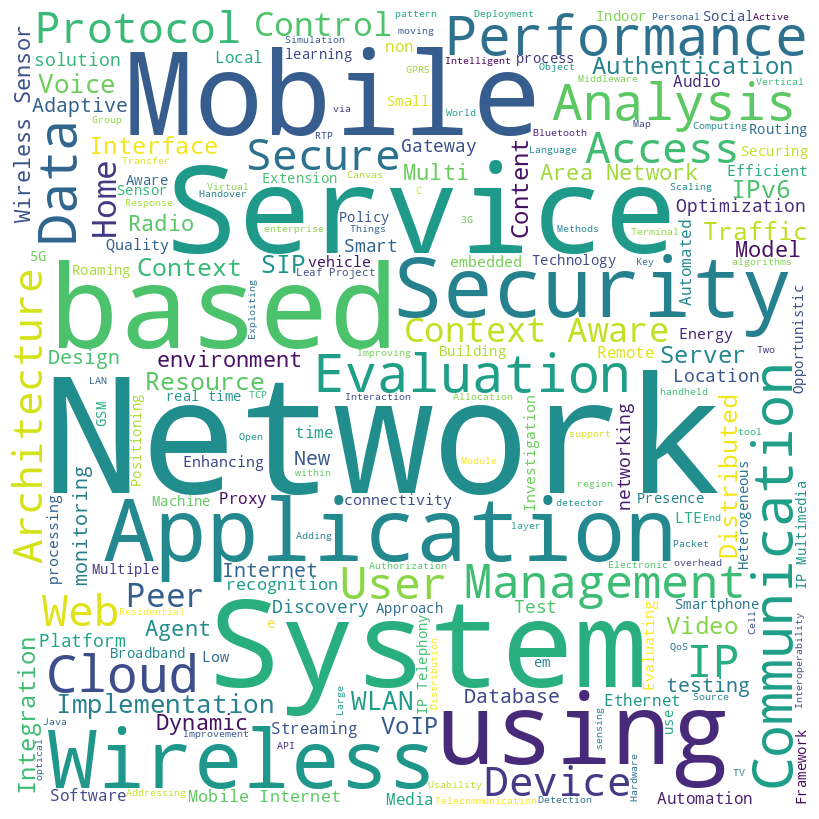

In [13]:
print(df.columns)
from wordcloud import WordCloud, STOPWORDS
title_comment_words = ''
stopwords = set(STOPWORDS)
stopwords.add('nan')

for idx, row in df.iterrows():
    title = row['title.eng']
    if isinstance(title, float):
        continue
    tokens = title.split(' ')
    # Converts each token into lowercase
    for i in range(len(tokens)):
        if any(map(str.isupper, tokens[i])):
            tokens[i] = tokens[i]
        else:
            tokens[i] = tokens[i].lower()
     
    title_comment_words += " ".join(tokens)+" "
 
title_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(title_comment_words)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(title_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Make a word cloud using the Swedish title

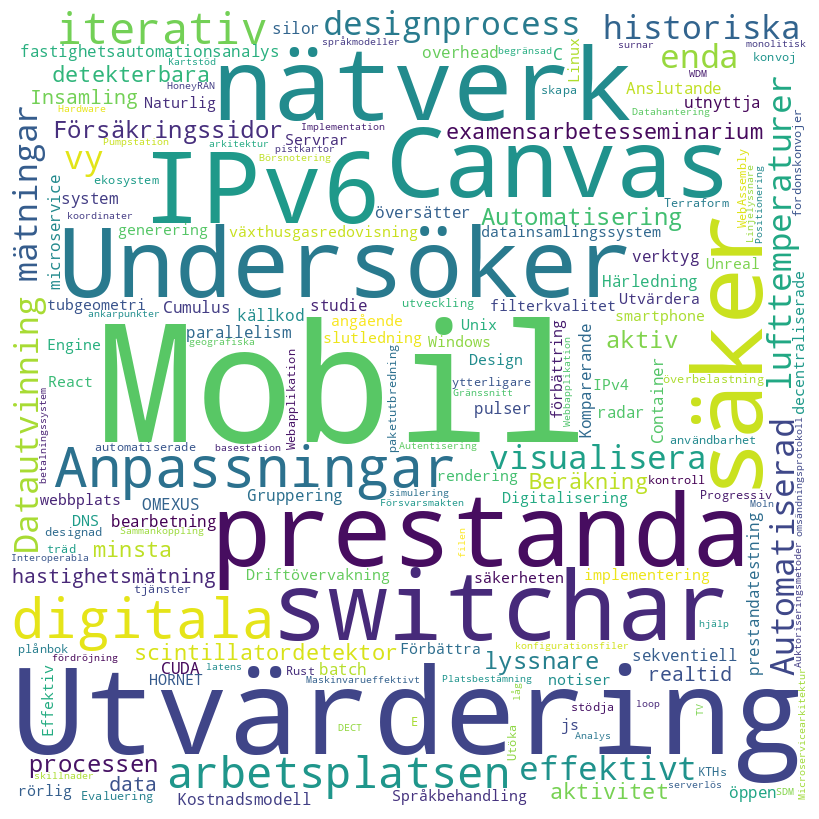

In [14]:
from wordcloud import WordCloud, STOPWORDS
title_comment_words = ''
stopwords = set(SwedishStopWords)
stopwords.update(set(STOPWORDS))
stopwords.add('nan')
stopwords.add('Language')
stopwords.add('Cooperative')
stopwords.add('Swedish')
stopwords.add('subtitle')

for idx, row in df.iterrows():
    title = row['title.swe']
    if isinstance(title, float):
        continue
    tokens = title.split(' ')

    # Converts each token into lowercase
    for i in range(len(tokens)):
        if any(map(str.isupper, tokens[i])):
            tokens[i] = tokens[i]
        else:
            tokens[i] = tokens[i].lower()
     
    title_comment_words += " ".join(tokens)+" "
 
title_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(title_comment_words)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(title_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [15]:
for idx, row in df.iterrows():
    title = row['title.swe']
    if isinstance(title, float):
        continue
    print(f'{title}')

Anpassningar för den digitala arbetsplatsen Swedish subtitle
En iterativ designprocess for att visualisera historiska lufttemperaturer mätningar effektivt i en enda vy
Automatiserad Datautvinning från Försäkringssidor
Automatisering av aktiv lyssnare processen inom examensarbetesseminarium
Beräkning av minsta detekterbara aktivitet för en mobil scintillatordetektor med hastighetsmätning i realtid
Insamling av data för fastighetsautomationsanalys
Komparerande studie av verktyg för prestandatestning med öppen källkod jämfört med OMEXUS
Anslutande silor
Container overhead i microservice-system
Cumulus - översätter CUDA till sekventiell C++
Gruppering av radar pulser med batch-bearbetning för att utnyttja parallelism
Härledning av en Kostnadsmodell med växthusgasredovisning angående slutledning inom Naturlig Språkbehandling
Design och implementering av ett datainsamlingssystem med filterkvalitet utvärdering
Digitalisering av notiser med en rörlig smartphone
DNS prestanda
Driftövervakning a

## Calculate some statistics on the dates: DefenceDate, CreatedDate,  and PublicationDate

One of the ideas of this part of the analysis was to show that one can create the columns of a Python Pandas dataframe to have the date types that you want. Another idea of this part of the notebook was to look at the time intervals between the oral presentation (defenceDate) and the creation of the DiVA page and when the DiVA page was published.

In [16]:
# do some statistics on the dates: DefenceDate, CreatedDate,  and PublicationDate

number_with_defenceDate=0
number_with_createdDate=0
number_with_publicationDate=0

dates_df=pd.DataFrame({
    'PID': pd.Series(dtype='int'),
    'Year': pd.Series(dtype='int'),
    'DefenceDate': pd.Series(dtype='datetime64[ns]'),
    'CreatedDate': pd.Series(dtype='datetime64[ns]'),
    'PublicationDate': pd.Series(dtype='datetime64[ns]'),
    'delta_created': pd.Series(dtype='int'),
    'delta_publication': pd.Series(dtype='int')
})

for idx, row in df.iterrows():
    defense_date=None
    created_date=None
    publication_date=None
    year=None

    #pid=str(row['PID'])
    pid=str(row['node'])
    dates_df.loc[idx,'PID']=int(pid)
    year=str(row['Year'])
    if year:
        dates_df.loc[idx,'Year']=int(year)

    defense_date_str=str(row['DefenceDate']) # will have the form: 2022-05-24T13:00
    if len(defense_date_str) == 16:
        # convert the string into a python date and time
        defense_date=datetime.strptime(defense_date_str, '%Y-%m-%dT%H:%M')
        dates_df.loc[idx,'DefenceDate']=defense_date
        number_with_defenceDate=number_with_defenceDate+1

    created_date_str=str(row['CreatedDate'])
    if len(created_date_str) == 10:
        #
        created_date=datetime.strptime(created_date_str, '%Y-%m-%d')
        dates_df.loc[idx,'CreatedDate']=created_date
        number_with_createdDate=number_with_createdDate+1

    publication_date_str=str(row['PublicationDate'])
    if len(publication_date_str) == 10:
        #
        publication_date=datetime.strptime(publication_date_str, '%Y-%m-%d')
        dates_df.loc[idx,'PublicationDate']=publication_date
        number_with_publicationDate=number_with_publicationDate+1
    
    if defense_date and created_date:
        dates_df.loc[idx,'delta_created']=int((created_date-defense_date).days)
    if created_date and publication_date:
        dates_df.loc[idx,'delta_publication']=int((publication_date-created_date).days)

print("number_with_defenceDate={0}, number_with_createdDate={1},number_with_publicationDate={2}".format(number_with_defenceDate, number_with_createdDate, number_with_publicationDate))
                     

KeyError: 'DefenceDate'

In [ ]:
_deepnote_run_altair(dates_df, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Year","scale":{"type":"time","zero":false}},"y":{"sort":null,"type":"quantitative","field":"delta_publication","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

As shown in the plot below, the time between the defense and the creation of the record in DiVA goes down rather rapidly in 2012, when I started putting the meta data for all of the old theses that I had previously had into DiVA. After this point the time between the defence and the creation of a record in DiVA is very short (as will be shown in yet another plot). 

In [ ]:
_deepnote_run_altair(dates_df, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Year","scale":{"type":"time","zero":false}},"y":{"sort":null,"type":"quantitative","field":"delta_created","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [ ]:
dates_df_since_2012=dates_df[dates_df['Year'] > 2012]
negative_dates=dates_df_since_2012[dates_df_since_2012['delta_created'] < 0]
negative_dates.head()

PID    Year         DefenceDate CreatedDate PublicationDate  \
333  727954.0  2014.0 2014-06-17 13:00:00  2012-10-31      2014-06-24   

     delta_created  delta_publication  
333         -595.0              601.0

Note that the thesis which has a created date 600 days before the oral presentation is likley to be an error in the data and it has been reported to the library. It is very suspecious as the created date is automatically entered by the DiVA system, but it is unlikely that I knew that a thesis was going to be completed 600 days later!

In [ ]:
_deepnote_run_altair(dates_df_since_2012, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Year","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"delta_created","scale":{"type":"time","zero":false}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

## 

## Some statistics about defense dates - totals by year, month, date, and hour

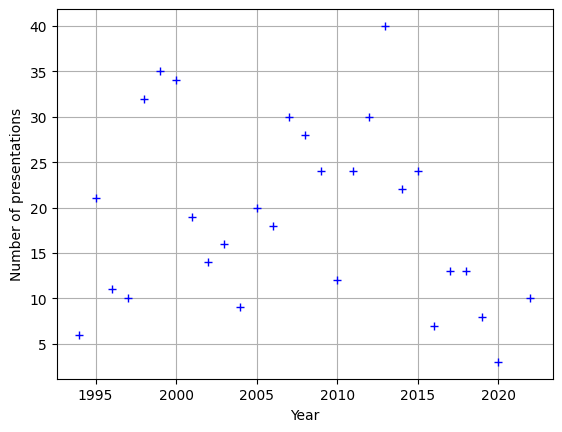

In [ ]:
# dates_df has columns 'Year' and 'DefenceDate'
total_defenses_per_year=dict()
def increment_per_year(y):
    global total_defenses_per_year
    current_total=total_defenses_per_year.get(y, 0)
    total_defenses_per_year[y]=current_total+1
    #print("{0}: {1}".format(y, current_total))

total_defenses_per_month=dict()
def increment_per_month(m):
    global total_defenses_per_month
    current_total=total_defenses_per_month.get(m, 0)
    total_defenses_per_month[m]=current_total+1

total_defenses_per_day=dict()
def increment_per_day(d):
    global total_defenses_per_day
    current_total=total_defenses_per_day.get(d, 0)
    total_defenses_per_day[d]=current_total+1

total_defenses_per_hour=dict()
def increment_per_hour(h):
    global total_defenses_per_hour
    current_total=total_defenses_per_hour.get(h, 0)
    total_defenses_per_hour[h]=current_total+1

for idx, row in dates_df.iterrows():
    defense_date=row['DefenceDate']
    if type(defense_date) is pd.Timestamp and defense_date.year > 1990:
        dates_df.loc[idx,'DefenceDate year']=defense_date.year
        increment_per_year(defense_date.year)
        dates_df.loc[idx,'DefenceDate month']=defense_date.month
        increment_per_month(defense_date.month)
        dates_df.loc[idx,'DefenceDate day']=defense_date.day
        increment_per_day(defense_date.day)
        dates_df.loc[idx,'DefenceDate hour']=defense_date.hour
        increment_per_hour(defense_date.hour)

lists = sorted(total_defenses_per_year.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax=plt.subplots(1, 1)
plt.plot(x, y, 'b+')
plt.xlabel("Year")
plt.ylabel("Number of presentations")
ax.grid('on')
plt.show()


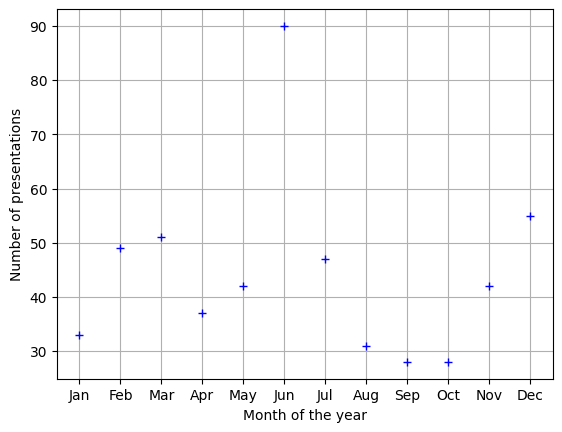

In [ ]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
lists = sorted(total_defenses_per_month.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax=plt.subplots(1, 1)
plt.plot(x, y, 'b+')
plt.xlabel("Month of the year")
plt.ylabel("Number of presentations")
months_dict={'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
ax.set_xticks(x)
ax.set_xticklabels(months_dict.keys())
ax.grid('on')
plt.show()


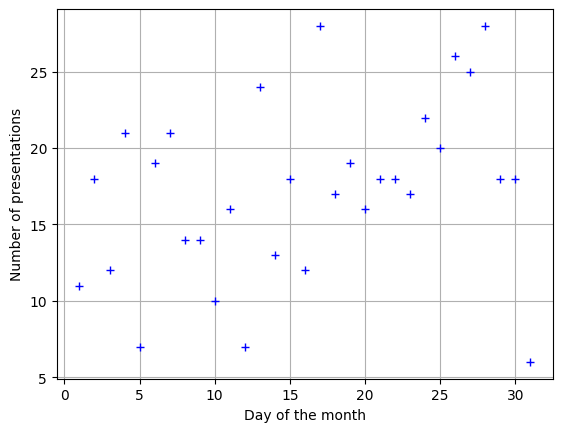

In [ ]:
lists = sorted(total_defenses_per_day.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax=plt.subplots(1, 1)
plt.plot(x, y, 'b+')
plt.xlabel("Day of the month")
plt.ylabel("Number of presentations")
ax.grid('on')
plt.show()


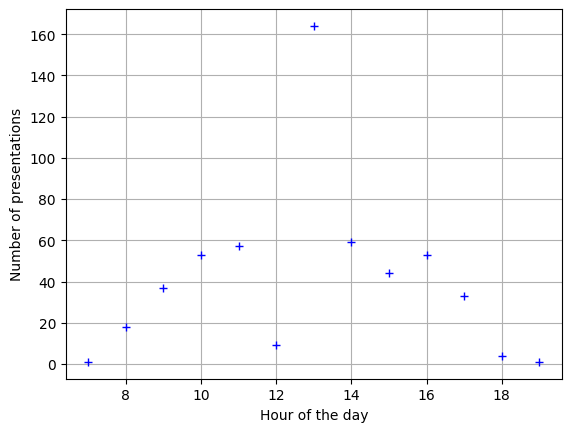

In [ ]:
lists = sorted(total_defenses_per_hour.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
fig, ax=plt.subplots(1, 1)
plt.plot(x, y, 'b+')
plt.xlabel("Hour of the day")
plt.ylabel("Number of presentations")
ax.grid('on')
plt.show()

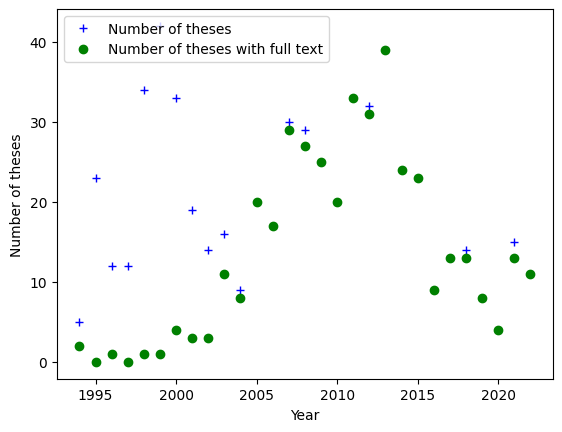

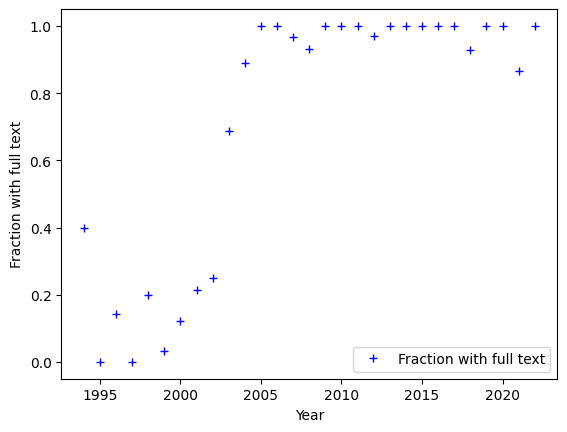

In [ ]:
fulltext=dict()
# key=year
#    'Number'
#    'Number_with_full_text'
fulltext_fraction=dict()
# key=year
#    'Fraction'

for idx, row in df.iterrows():
    year=row['Year']
    fullTextLink=row['FullTextLink']
    years_data=fulltext.get(year, {'Number': 0, 'Number_with_full_text': 0, 'Fraction': 0.0})
    years_data['Number']=years_data['Number']+1
    if isinstance(fullTextLink, float):
        continue
    if (isinstance(fullTextLink, str) and len(fullTextLink) > 0):
        years_data['Number_with_full_text']=years_data['Number_with_full_text']+1
        fulltext_fraction[year]=years_data['Number_with_full_text']/years_data['Number']
    fulltext[year]=years_data

fulltext_df=pd.DataFrame(columns=['year', 'Number', 'Number_with_full_text'])
for yd in sorted(fulltext.keys()):
    fulltext_df.loc[yd, 'year']=int(yd)
    fulltext_df.loc[yd, 'Number']=fulltext[yd]['Number']
    fulltext_df.loc[yd, 'Number_with_full_text']=fulltext[yd].get('Number_with_full_text', 0)

fulltext_df.astype({'year': int, 'Number': int, 'Number_with_full_text': int})
#fulltext_df.head()
#fulltext_df.describe
years=[]
numbers=[]
number_with_full_text=[]
fraction_with_full_text=[]
for yd in sorted(fulltext.keys()):
    years.append(int(yd))
    numbers.append(fulltext[yd]['Number'])
    number_with_full_text.append(fulltext[yd].get('Number_with_full_text', 0))
    fraction_with_full_text.append(fulltext_fraction.get(yd, 0))

p1, = plt.plot(years, numbers, 'b+', label='Number of theses')
p2, = plt.plot(years, number_with_full_text, 'go', label='Number of theses with full text')
plt.xlabel("Year")
plt.ylabel("Number of theses")
ax.grid('on')
plt.legend(loc="upper left")
plt.show()

plt.plot(years, fraction_with_full_text, 'b+', label='Fraction with full text')
plt.xlabel("Year")
plt.ylabel("Fraction with full text")
ax.grid('on')
plt.legend(loc="lower right")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5141ba30-b9ac-441d-a8e4-4eda1b001af6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>